In [16]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run initMethods_sparse.py
%run makeGif.py
%run methods_parallel_sparse.py
%run ../QuickSimulation2D/initMethods.py

In [9]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":             100,
    "R0":              20,
    "M":                1, #Also L, total number of spacers
    "D":                3, #Unused
    "mu":             0.02, #mutation rate
    "v0":              10,
    "gamma_shape":     20, 
    "Np":               0, #Number of Cas Protein
    "dc":               3, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":              1000, #cross-reactivity kernel
    "rho":            5e-5, #spacer sharing coeff
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "t0":                           0, 
    "tf":                         100,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_var_n":               10,
    "initial_mean_nh":          [0,0],
    "initial_var_nh":              10,
    "n_step_prior":                 5,
    "conv_size":                  100,
    "num_threads":                  4,
    "tail_axis":               [1, 1],
}

In [10]:
n = init_guassian_parallel(params["N0"], sim_params)

In [11]:
nh = init_uniform_parallel(params["Nh"], sim_params)

In [17]:
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel = init_kernel(params, sim_params)

In [54]:
x_ind_nh, y_ind_nh = nh.nonzero()
x_ind_n, y_ind_n = n.nonzero()
conv_size = sim_params["conv_size"]
xdomain = sim_params["xdomain"]
Nh = params["Nh"]
M = params["M"]
r = params["r"]
num_threads = sim_params["num_threads"]

ind_nh_subsets = zip(np.array_split(x_ind_nh, num_threads), np.array_split(y_ind_nh, num_threads))
ind_n_subsets = zip(np.array_split(x_ind_n, num_threads), np.array_split(y_ind_n, num_threads))

input_h = np.divide(nh, Nh)

def convolve_subset(ind_nh, ind_n):
    res = scipy.sparse.dok_matrix(nh.shape, dtype=float)
    for x_nh, y_nh in zip(x_ind_nh, y_ind_nh):
        for x_n, y_n in zip(x_ind_n, y_ind_n):

            x_kernel = np.abs(x_nh-x_n)
            y_kernel = np.abs(y_nh-y_n)

            if np.any((x_kernel >= conv_size, y_kernel>= conv_size)):
                continue
            
            value = input_h[x_nh, y_nh]
            
            try:
                interaction = kernel_quarter[x_kernel, y_kernel]
                # dist = x_kernel**2 + y_kernel**2
                # interaction = np.exp(-np.sqrt(dist)/r)
            except(IndexError):
                print("wtf? Convolution out of Bounds??", x_kernel, y_kernel)
                break
            
            # print(interaction)
            res[x_n, y_n] += value*interaction
    return res

results = Parallel(n_jobs=num_threads)(delayed(convolve_subset)
    (ind_nh_subset, ind_n_subset) for ind_nh_subset, ind_n_subset 
        in zip(ind_nh_subsets, ind_n_subsets))

out = np.sum(results, axis=0)/M

In [6]:
A = np.load("testSparseConv.npy")

In [48]:
B = scipy.signal.convolve2d(nh.todense()/(params["Nh"]*params["M"]), kernel)

In [49]:
C = np.zeros(nh.shape)
x_ind, y_ind = np.nonzero(n)
C[x_ind, y_ind] = B[x_ind, y_ind]

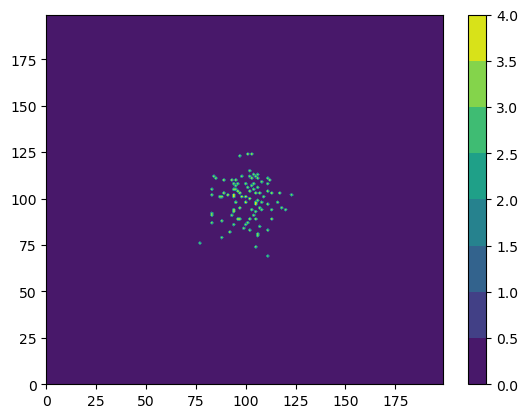

In [55]:
plt.contourf(out.todense())
plt.colorbar()

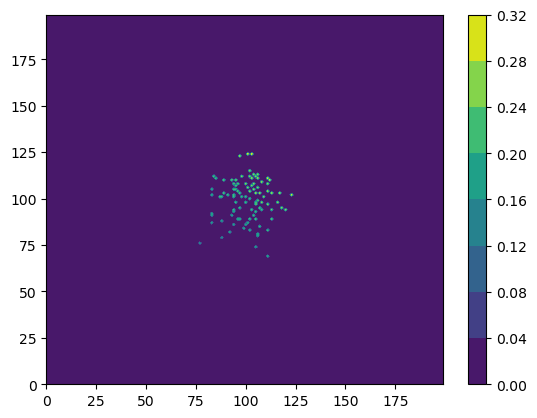

In [56]:
plt.contourf(C)
plt.colorbar()

In [111]:
np.save("testSparseConv.npy", dense)

In [ ]:
convolve_subset(zip(x_ind_nh, y_ind_nh), zip(x_ind_n, y_ind_n))

In [147]:
p = nh/(params["Nh"]*params["M"])

In [152]:
f = fitness_spacers_parallel(n, nh, p, params, sim_params)

NotImplementedError: subtracting a sparse matrix from a nonzero scalar is not supported

In [ ]:
f = fitness_spacers(n, nh, p, params, sim_params) #f is now a masked array (where mask is where eff_R0 = 0)
n = virus_growth(n, f, params, sim_params) #update


n = mutation_parallel(n, params, sim_params)
nh = immunity_update_parallel(nh, n, params, sim_params)